In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np 
import camb 

from lensit.clusterlens import lensingmap 

import os.path as op
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.interpolate import UnivariateSpline as spline
import lensit as li
from lensit.ffs_covs import ffs_cov, ell_mat


In [2]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.figsize'] = 8.5, 5.5

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('text', usetex=True)
mpl.rcParams['errorbar.capsize'] = 4
mpl.rc('legend', fontsize=15)

In [3]:
# We start by intiating CAMB which will give us the relevant cosmology 
cambinifile = 'planck_2018_acc'

pars = camb.read_ini(op.join(op.dirname(camb.__path__[0]),  'inifiles', cambinifile + '.ini'))
# pars.set_for_lmax(20000)
# pars.set_accuracy(2)
results = camb.get_results(pars)


In [4]:
# We define here the parameters for the profile of the cluster
M200 = 1e15
z = 1
profname = 'nfw'
profparams={'M200c':M200, 'z':z}

# Define here the map square patches
npix = 64  # Number of pixels
lpix_amin = 0.3 # Physical size of a pixel in arcmin (There is bug when <0.2 amin, due to low precision in Cl_TE at )

# Maximum multipole used to generate the CMB maps from the CMB power spectra
ellmaxsky = 6000 # (bug when ellmax>6300 because of low precision in Cl_TE of CAMB )

# Number of simulated maps 
nsims = 1 

# Set CMB experiment for noise level and beam
# cmb_exp='5muKamin_1amin'
# cmb_exp='S5'
cmb_exp = 'S4_opti'

# We will cache things in this directory 
libdir = lensingmap.get_cluster_libdir(cambinifile, profname, npix, lpix_amin, ellmaxsky, M200, z, nsims, cmb_exp)
print(libdir)

/Users/louis/Code/LensIt/lensit_write/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_opti/nfw_profile/npix64_lpix_0.3amin_lmaxsky6000/M200_1.000000E+15_z1/1_sims


In [5]:
# Instantiate the class containing the simulated maps 

clustermaps = lensingmap.cluster_maps(libdir, npix, lpix_amin, nsims, results, profparams, profilename=profname,  ellmax_sky = ellmaxsky, cmb_exp=cmb_exp)


/Users/louis/Code/LensIt/lensit/clusterlens/profile.py:280: RuntimeWarning: invalid value encountered in true_divide
  dx_lm = 2 * rfft_kappa * 1.j * KX / (KX**2+KY**2)
/Users/louis/Code/LensIt/lensit/clusterlens/profile.py:281: RuntimeWarning: invalid value encountered in true_divide
  dy_lm = 2 * rfft_kappa * 1.j * KY / (KX**2+KY**2)


In [6]:
# R = clustermaps.haloprofile.theta_amin_to_r(z, theta[1:])
xmax = 3
xmin = 0.05
rs = clustermaps.haloprofile.get_rs(M200, z)
# R = np.geomspace(xmin*rs, 1.5*xmax*rs, num = 50)
R = np.linspace(xmin*rs, 1.5*xmax*rs, num = 100)

# for i, R in enumerate(rarr):
# sigma_int =  clustermaps.haloprofile.sigma_int(M200, z, R, xmax=xmax, npoints=1000000)

In [7]:
clustermaps.haloprofile.get_concentration(M200, z)

2.528563070979895

Text(0, 0.5, '$\\Sigma(R)$')

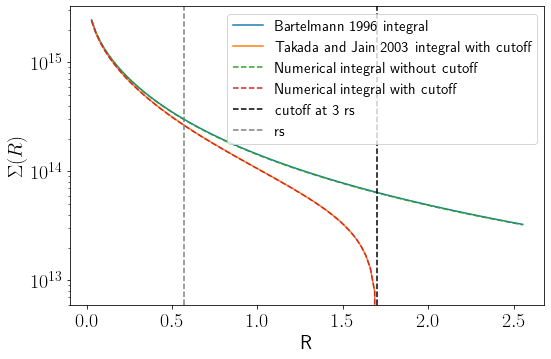

In [8]:

plt.plot(R, clustermaps.haloprofile.sigma_nfw(M200, z, R), label='Bartelmann 1996 integral')
plt.plot(R, clustermaps.haloprofile.sigma_nfw(M200, z, R, xmax=xmax), label='Takada and Jain 2003 integral with cutoff')


plt.plot(R, clustermaps.haloprofile.sigma_int(M200, z, R, xmax=100*xmax, npoints=100000), label='Numerical integral without cutoff', ls='--')


plt.plot(R, clustermaps.haloprofile.sigma_int(M200, z, R, xmax=xmax, npoints=100000), label='Numerical integral with cutoff', ls='--')


# plt.loglog()
plt.semilogy()

plt.axvline(x=rs*xmax, ls='--', c='k', label=f'cutoff at {xmax} rs')
plt.axvline(x=rs, ls='--', c='grey', label=f'rs')
plt.legend()

plt.xlabel('R')
plt.ylabel(r'$\Sigma(R)$')

Text(0, 0.5, '$\\theta \\;[\\mathrm{arcmin}]$')

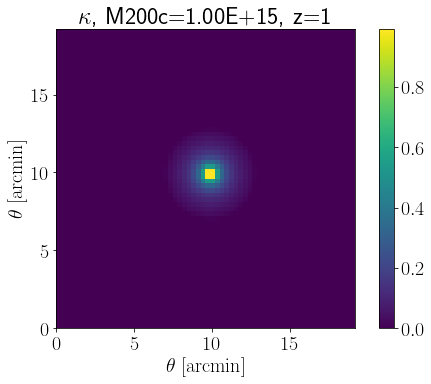

In [9]:
# And we can plot the 2D kappa map

# xmax = 6
xmax = clustermaps.haloprofile.get_concentration(M200, z) 

kappamap = clustermaps.haloprofile.kappa_map(M200, z, shape = clustermaps.lib_skyalm.shape, lsides = clustermaps.lib_skyalm.lsides, xmax=xmax)


masked_array = np.ma.masked_where(kappamap == 0, kappamap)

cmap = mpl.cm.get_cmap("viridis").copy()  # Can be any colormap that you want after the cm
cmap.set_bad(color='white')

# plt.imshow(masked_array, origin='lower', extent=[0, clustermaps.lpix_amin*clustermaps.npix, 0, clustermaps.lpix_amin*clustermaps.npix])
plt.imshow(kappamap, origin='lower', extent=[0, clustermaps.lpix_amin*clustermaps.npix, 0, clustermaps.lpix_amin*clustermaps.npix])
plt.colorbar()
plt.title(r'$\kappa$, M200c={:.2E}, z={}'.format(M200, z))
plt.xlabel(r'$\theta \;[\mathrm{arcmin}]$')
plt.ylabel(r'$\theta \;[\mathrm{arcmin}]$')



In [10]:
def cli(cl):
    ret = np.zeros_like(cl)
    ret[np.where(cl > 0)] = 1. / cl[np.where(cl > 0)]
    return ret

def pp_to_kk(ls):
    return ls ** 2 * (ls+1) ** 2 * 0.25 

def kk_to_pp(ls):
    return cli(pp_to_kk(ls))

In [11]:
ellmax_sky = clustermaps.ellmax_sky
sN_uKamin, sN_uKaminP, Beam_FWHM_amin, ellmin, ellmax = li.get_config(clustermaps.cmb_exp)

cls_noise = {'t': (sN_uKamin * np.pi / 180. / 60.) ** 2 * np.ones(clustermaps.ellmax_sky + 1),
            'q':(sN_uKaminP * np.pi / 180. / 60.) ** 2 * np.ones(clustermaps.ellmax_sky + 1),
            'u':(sN_uKaminP * np.pi / 180. / 60.) ** 2 * np.ones(clustermaps.ellmax_sky + 1)}  # simple flat noise Cls
# cl_transf = gauss_beam(Beam_FWHM_amin / 60. * np.pi / 180., lmax=ellmax_sky)
# lib_alm = ell_mat.ffs_alm_pyFFTW(get_ellmat(LD_res, HD_res=HD_res),
                    # filt_func=lambda ell: (ell >= ellmin) & (ell <= ellmax), num_threads=pyFFTWthreads)
# lib_skyalm = ell_mat.ffs_alm_pyFFTW(clustermaps.ellmat,
                    # filt_func=lambda ell: (ell <= ellmax_sky), num_threads=clustermaps.num_threads)

cl_transf = clustermaps.cl_transf
lib_skyalm = clustermaps.lib_skyalm


typ = 'T'

lib_dir = op.join(clustermaps.dat_libdir, typ)
# isocov = ffs_cov.ffs_diagcov_alm(lib_dir, clustermaps.lib_datalm, clustermaps.cls_unl, cls_len, cl_transf, cls_noise, lib_skyalm=lib_skyalm)
isocov = ffs_cov.ffs_diagcov_alm(lib_dir, clustermaps.lib_datalm, clustermaps.cls_unl, clustermaps.cls_unl, cl_transf, cls_noise, lib_skyalm=lib_skyalm)


In [12]:
lib_skyalm = clustermaps.lib_skyalm

ell, = np.where(lib_skyalm.get_Nell()[:ellmaxsky+1])

ckk_map = lib_skyalm.map2cl(kappamap)


kappa_ell = clustermaps.haloprofile.analitic_kappa_ft(M200, z, np.arange(ellmaxsky+1))
ckk_fid = kappa_ell **2 

/Users/louis/Code/LensIt/lensit/clusterlens/profile.py:178: RuntimeWarning: invalid value encountered in subtract
  Cidiff = Cixpc - Cix
/Users/louis/Code/LensIt/lensit/clusterlens/profile.py:179: RuntimeWarning: invalid value encountered in true_divide
  u0 = np.sin(x) * Sidiff + np.cos(x) * Cidiff - np.sin(x * c) / (x * (1. + c))


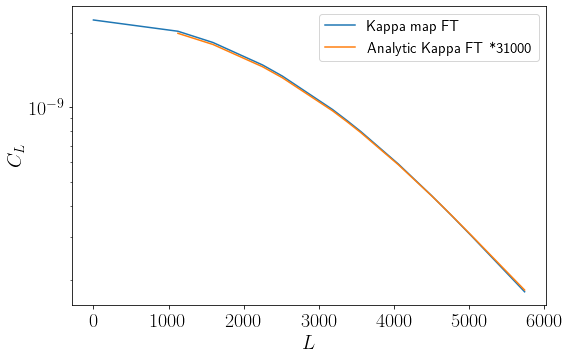

In [13]:
plt.plot(ell, ckk_map[ell], label='Kappa map FT')
plt.plot(ell, ckk_fid[ell]*3.1e4, label='Analytic Kappa FT *31000')

plt.semilogy()

plt.xlabel(r'$L$')
plt.ylabel(r'$C_L$')

plt.legend()

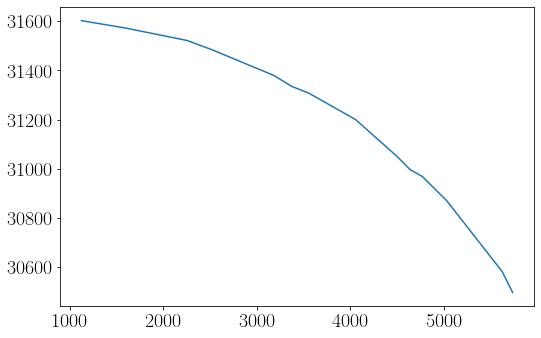

In [14]:
plt.plot(ell, ckk_map[ell]/ckk_fid[ell])

In [15]:
alm = np.ones_like(lib_skyalm.map2alm(kappamap))


In [16]:
# Make a map from the analytical FT 
        # tmap = lib_skyalm.almxfl(kappa_ell, self.cl_transf)



kft_lm = np.ones_like(lib_skyalm.map2alm(kappamap))


kappa_ell[0] = 0
lib_skyalm.almxfl(kft_lm, kappa_ell, inplace=True)
# kft_lm[0] = 0
kftmap = lib_skyalm.alm2map(kft_lm)

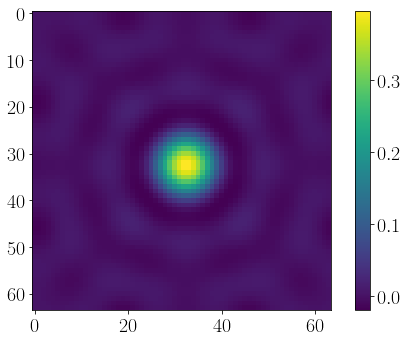

In [17]:
plt.imshow(lib_skyalm.alm2map(lib_skyalm.map2alm(kappamap)))
plt.colorbar()

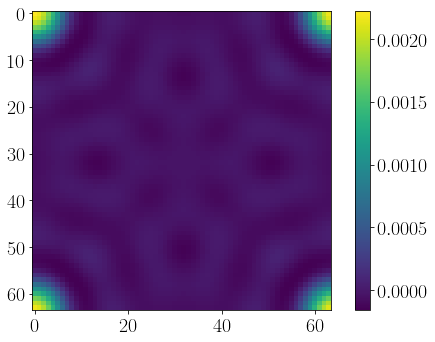

In [18]:
plt.imshow(kftmap)
plt.colorbar()


In [19]:
# You can access the lensed and unlensed CMB maps with get_len_map and get_unl_map

idx = 0 # Simulation index
field = 't' # Access the temperature field 't', or the polarization fields 'e' or 'b', or 'q' and 'u'
map_unl = clustermaps.get_unl_map(idx, field)
map_len = clustermaps.get_len_map(idx, field)
map_obs = clustermaps.get_obs_map(idx, field)
# map_noise = clustermaps.get_noise_map(idx, field)


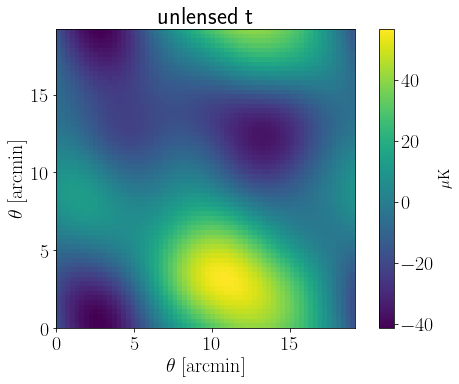

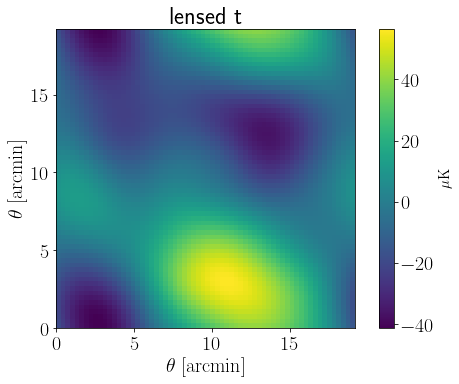

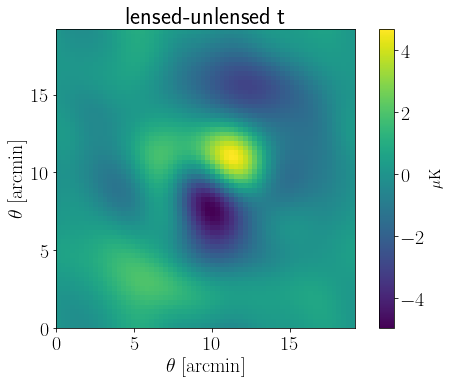

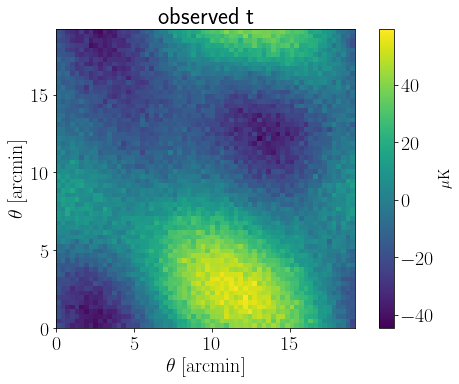

In [20]:
for i, (mp, title) in enumerate(zip([map_unl, map_len, map_len-map_unl, map_obs], ['unlensed', 'lensed', 'lensed-unlensed', 'observed'])):
    plt.figure()
    plt.imshow(mp, origin='lower', extent=[0, clustermaps.lpix_amin*clustermaps.npix, 0, clustermaps.lpix_amin*clustermaps.npix])
    plt.title(title + '  %s' % field)
    plt.xlabel(r'$\theta \;[\mathrm{arcmin}]$')
    plt.ylabel(r'$\theta \;[\mathrm{arcmin}]$') 
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(r'$\mu \mathrm{K}$',fontsize=15)